# Candidate Expectations
Your task is to execute the process for proactive detection of fraud while answering following
questions.
1. Data cleaning including missing values, outliers and multi-collinearity.
2. Describe your fraud detection model in elaboration.
3. How did you select variables to be included in the model?
4. Demonstrate the performance of the model by using best set of tools.
5. What are the key factors that predict fraudulent customer?
6. Do these factors make sense? If yes, How? If not, How not?
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
data = pd.read_csv("Fraud.csv")
data.shape

(6362620, 11)

In [5]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


##  Investigating the data set in order to identify fraudulent activity before it occurs, and addressing related questions..

In [6]:
data.isnull().values.any()

False

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
legit_transactions = data[data.isFraud == 0].shape[0]
fraud_transactions = data[data.isFraud == 1].shape[0]
legit_transactions_percent = (legit_transactions / (legit_transactions + fraud_transactions)) * 100
fraud_transactions_percent = (fraud_transactions / (legit_transactions + fraud_transactions)) * 100

print("Total number of legitimate transactions: ", legit_transactions)
print("Total number of fraudulent transactions: ", fraud_transactions)
print("Percentage of legitimate transactions: {:.4f} %".format(legit_transactions_percent))
print("Percentage of fraudulent transactions: {:.4f} %".format(fraud_transactions_percent))

Total number of legitimate transactions:  6354407
Total number of fraudulent transactions:  8213
Percentage of legitimate transactions: 99.8709 %
Percentage of fraudulent transactions: 0.1291 %


## The analysis reveals a significant disparity in the distribution of legitimate and fraudulent transactions, with the former making up 99.87% and the latter only 0.13%. Given this imbalance, it is appropriate to use decision trees and random forests as appropriate methodologie

In [9]:
trader= data[data['nameDest'].str.contains('M', case=False)]
trader.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


## No attributes oldbalanceDest and newbalanceDest information is available for trader

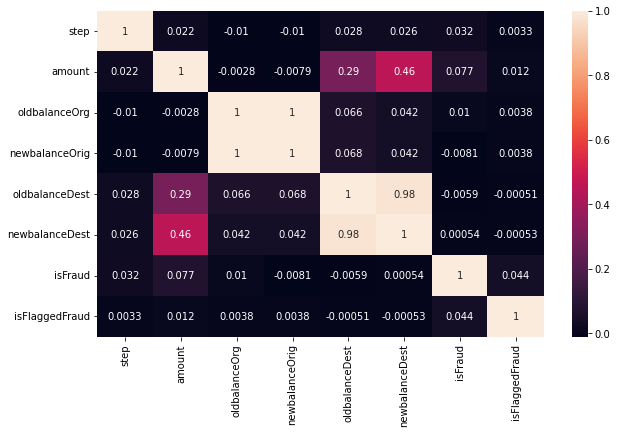

In [10]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr, annot=True, ax=ax)

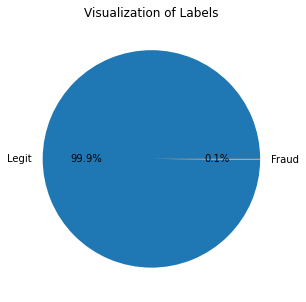

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
labels = ["Legit", "Fraud"]
counts = data['isFraud'].value_counts()
ax.pie(counts, labels=labels,autopct='%1.1f%%')
ax.set_title("Visualization of Labels")
plt.show()

## Creating a duplicate of the original dataset for model training and testing purposes

In [12]:
duplicate_data=data.copy()
duplicate_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
obj_cols = duplicate_data.select_dtypes(include=['object']).columns
print(obj_cols)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


### The dataset includes 3 attributes with object datatype. These need to be label-encoded to check for multicollinearity

In [14]:
encoder = LabelEncoder()

for feature in obj_cols:
   duplicate_data[feature] = encoder.fit_transform(duplicate_data[feature].astype(str))

print(duplicate_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(6)
memory usage: 534.0 MB
None


In [15]:
duplicate_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [16]:
def calcVIF(df):
    vif_df = pd.DataFrame(columns = ['feature', 'VIF'])
    vif_df["feature"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_df


In [17]:
calcVIF(duplicate_data)

,feature,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


###### As evident from the results, oldbalanceOrg and newbalanceOrig have a very high VIF, indicating a strong correlation between the two. Similarly, oldbalanceDest and newbalanceDest are also highly correlated. Additionally, nameDest is found to be related to nameOrig. To address this issue, these correlated pairs of attributes should be combined and the individual ones should be removed


In [18]:
duplicate_data['Actual_amount_orig'] = duplicate_data.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
duplicate_data['Actual_amount_dest'] = duplicate_data.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
duplicate_data['TransactionPath'] = duplicate_data.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

duplicate_data = duplicate_data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calcVIF(duplicate_data)

,feature,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


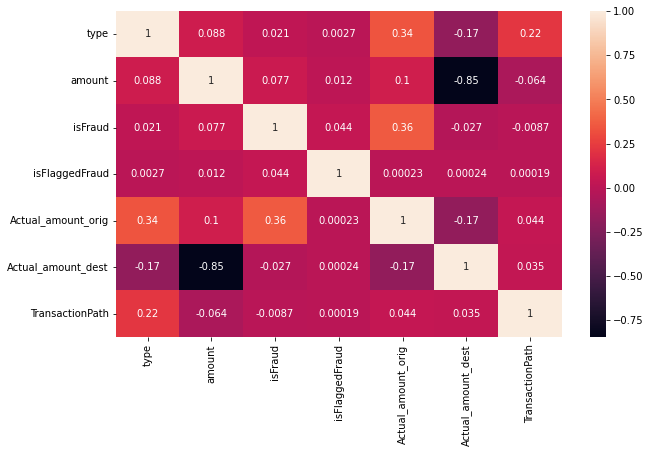

In [19]:
corr=duplicate_data.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

##### How did you select variables to be included in the model?

Ans. By analyzing the VIF values and the correlation heatmap, we can identify any pairs of attributes that have a high degree of correlation. We can then remove the attribute that has the lowest correlation with the isFraud attribute to reduce multicollinearity.

In [20]:
scaler = StandardScaler()
duplicate_data["NormalizedAmount"] = scaler.fit_transform(duplicate_data["amount"].values.reshape(-1, 1))
duplicate_data.drop(["amount"], inplace= True, axis= 1)

Y = duplicate_data["isFraud"]
X = duplicate_data.drop(["isFraud"], axis= 1)

### I chose to only normalize the 'amount' attribute in the dataset, as normalizing the entire dataset may negatively impact the accuracy of the model.


In [21]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


#### ##DecisionTree

In [22]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
predictions_c = clf.predict(X_test)
accuracy = clf.score(X_test, Y_test) * 100

print("Accuracy: {:.5f}%".format(accuracy))

Accuracy: 99.92184%


In [23]:
ran= RandomForestClassifier(n_estimators= 100)
ran.fit(X_train, Y_train)

predictions_r = ran.predict(X_test)
forest_score = ran.score(X_test, Y_test) * 100
print("random forest score: {:.5f}%".format(forest_score))

random forest score: 99.95919%


In [24]:
print("Decision Tree Classification Report:")
print(classification_report(Y_test, predictions_c ))
print("____________________________________________________________________________")
print("Random Forest Classification Report:")
print(classification_report(Y_test, predictions_r))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.69      0.71      0.70      2464

    accuracy                           1.00   1908786
   macro avg       0.85      0.86      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.97      0.71      0.82      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



Decision Tree


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


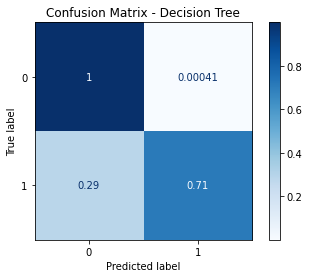

Random Forest


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


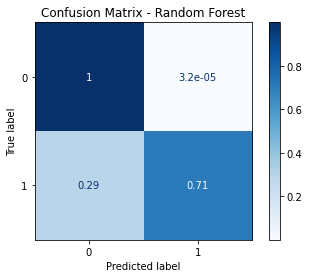

In [26]:
print("Decision Tree")
display = plot_confusion_matrix(clf, X_test, Y_test, cmap=plt.cm.Blues, normalize='true')
display.ax_.set_title("Confusion Matrix - Decision Tree")
plt.show()

print("Random Forest")
display = plot_confusion_matrix(ran, X_test, Y_test, cmap=plt.cm.Blues, normalize='true')
display.ax_.set_title("Confusion Matrix - Random Forest")
plt.show()

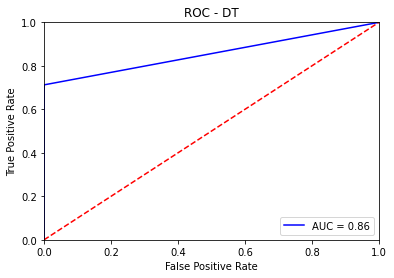

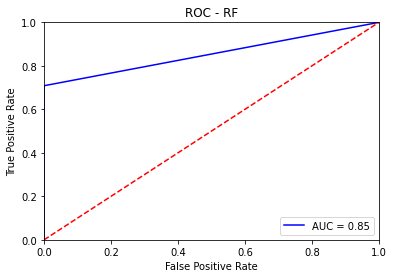

In [29]:

def plot_roc_curve(y_test, y_pred, model_name):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC - ' + model_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# call the function for decision tree model
plot_roc_curve(Y_test, predictions_c, "DT")

# call the function for random forest model
plot_roc_curve(Y_test, predictions_r, "RF")

In conclusion, we have found that both Random Forest and Decision Tree models have comparable accuracy. However, Random Forest has a higher precision, which is particularly important in a fraud detection model. This is because the goal is to correctly identify fraudulent transactions while minimizing false positives. This is one of the reasons why Random Forest and Decision Tree are commonly used in this application.

Additionally, the use of Random Forest is beneficial for handling unbalanced datasets, such as the one used in this study. Other models, such as XGBoost, Bagging, ANN, and Logistic Regression, may have high accuracy but may not produce satisfactory precision and recall results.

To prevent fraudulent activity, key factors to consider include the security of the source of the request, the legitimacy of the organization asking for money, the transaction history of vendors, and the adoption of security measures such as using verified apps and secured websites. To determine the effectiveness of these measures, banks can send e-statements, customers can monitor their account activity, and maintain a log of payments.